<a href="https://colab.research.google.com/github/PedroJuiz/NLP/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Analysis

### Pedro Juiz

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from gensim.models import Word2Vec

In [ ]:
df = pd.read_csv('twitter.csv/twitter.csv')

In [ ]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [ ]:
df = df.drop(columns=('id'), axis = 1)
df

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
31957,0,ate @user isz that youuu?ðððððð...
31958,0,to see nina turner on the airwaves trying to...
31959,0,listening to sad songs on a monday morning otw...
31960,1,"@user #sikh #temple vandalised in in #calgary,..."


In [ ]:
df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [ ]:
df['tweet_length'] = df['tweet'].apply(len)
print(df['tweet_length'].describe())

count    31962.000000
mean        84.739628
std         29.455749
min         11.000000
25%         63.000000
50%         88.000000
75%        108.000000
max        274.000000
Name: tweet_length, dtype: float64


In [ ]:
df.head(10)

,label,tweet,tweet_length
0,0,@user when a father is dysfunctional and is s...,102
1,0,@user @user thanks for #lyft credit i can't us...,122
2,0,bihday your majesty,21
3,0,#model i love u take with u all the time in ...,86
4,0,factsguide: society now #motivation,39
5,0,[2/2] huge fan fare and big talking before the...,116
6,0,@user camping tomorrow @user @user @user @use...,74
7,0,the next school year is the year for exams.ð...,143
8,0,we won!!! love the land!!! #allin #cavs #champ...,87
9,0,@user @user welcome here ! i'm it's so #gr...,50


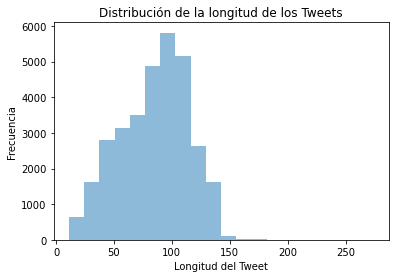

In [ ]:
plt.hist(df['tweet_length'], bins=20, alpha=0.5)
plt.title('Distribución de la longitud de los Tweets')
plt.xlabel('Longitud del Tweet')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_tweet(tweet):
    tweet = tweet.lower()

    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    tweet = re.sub(r'[^\x00-\x7F]+', ' ', tweet)

    word_tokens = word_tokenize(tweet)

    filtered_tweet = [lemmatizer.lemmatize(word) for word in word_tokens if word not in stop_words]

    return " ".join(filtered_tweet)

df['processed_tweet'] = df['tweet'].apply(preprocess_tweet)

In [ ]:
df.head(10)

,label,tweet,tweet_length,processed_tweet
0,0,@user when a father is dysfunctional and is s...,102,user father dysfunctional selfish drag kid dys...
1,0,@user @user thanks for #lyft credit i can't us...,122,user user thanks lyft credit cant use cause do...
2,0,bihday your majesty,21,bihday majesty
3,0,#model i love u take with u all the time in ...,86,model love u take u time ur
4,0,factsguide: society now #motivation,39,factsguide society motivation
5,0,[2/2] huge fan fare and big talking before the...,116,22 huge fan fare big talking leave chaos pay d...
6,0,@user camping tomorrow @user @user @user @use...,74,user camping tomorrow user user user user user...
7,0,the next school year is the year for exams.ð...,143,next school year year exam cant think school e...
8,0,we won!!! love the land!!! #allin #cavs #champ...,87,love land allin cavs champion cleveland clevel...
9,0,@user @user welcome here ! i'm it's so #gr...,50,user user welcome im gr8


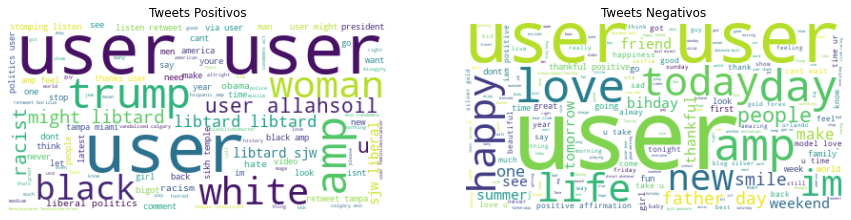

In [ ]:
positive_text = " ".join(tweet for tweet, label in zip(df.processed_tweet, df.label) if label == 1)
negative_text = " ".join(tweet for tweet, label in zip(df.processed_tweet, df.label) if label == 0)

positive_wordcloud = WordCloud(background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(background_color='white').generate(negative_text)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Tweets Positivos')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Tweets Negativos')
plt.axis('off')

plt.show()

## Embeddings con Word2VEC

In [ ]:
sentences = [row.split() for row in df['processed_tweet']]
w2v_model = Word2Vec(sentences, min_count=1)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['processed_tweet'])
max_len = max([len(s.split()) for s in df['processed_tweet']])

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, w2v_model.vector_size))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

sequences = tokenizer.texts_to_sequences(df['processed_tweet'])
X = pad_sequences(sequences, maxlen=max_len)

labels = to_categorical(df['label'])

model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, w2v_model.vector_size, weights=[embedding_matrix],
                    input_length=max_len, trainable=False))
model.add(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.15))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.15))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
800/800 [==============================] - 119s 145ms/step - loss: 0.2128 - accuracy: 0.9312 - val_loss: 0.1888 - val_accuracy: 0.9331
Epoch 2/10
800/800 [==============================] - 115s 144ms/step - loss: 0.1901 - accuracy: 0.9349 - val_loss: 0.1895 - val_accuracy: 0.9293
Epoch 3/10
800/800 [==============================] - 115s 143ms/step - loss: 0.1811 - accuracy: 0.9368 - val_loss: 0.1763 - val_accuracy: 0.9348
Epoch 4/10
800/800 [==============================] - 115s 143ms/step - loss: 0.1764 - accuracy: 0.9377 - val_loss: 0.1756 - val_accuracy: 0.9365
Epoch 5/10
800/800 [==============================] - 116s 145ms/step - loss: 0.1723 - accuracy: 0.9384 - val_loss: 0.1700 - val_accuracy: 0.9376
Epoch 6/10
800/800 [==============================] - 116s 145ms/step - loss: 0.1668 - accuracy: 0.9404 - val_loss: 0.1641 - val_accuracy: 0.9387
Epoch 7/10
800/800 [==============================] - 116s 145ms/step - loss: 0.1633 - accuracy: 0.9402 - val_loss: 0.1651 -

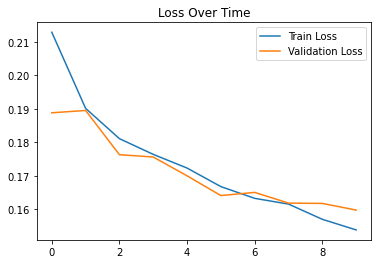

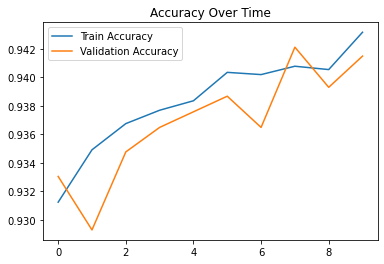

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.legend()
plt.show()

## Embeddings con LSTM

In [ ]:
labels = to_categorical(df['label'], num_classes=2)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['processed_tweet'])

sequences = tokenizer.texts_to_sequences(df['processed_tweet'])
max_len = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_len)

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len))
model.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
800/800 [==============================] - 56s 66ms/step - loss: 0.1666 - accuracy: 0.9493 - val_loss: 0.1180 - val_accuracy: 0.9587
Epoch 2/10
800/800 [==============================] - 52s 65ms/step - loss: 0.0623 - accuracy: 0.9795 - val_loss: 0.1248 - val_accuracy: 0.9643
Epoch 3/10
800/800 [==============================] - 52s 65ms/step - loss: 0.0291 - accuracy: 0.9909 - val_loss: 0.1425 - val_accuracy: 0.9609
Epoch 4/10
800/800 [==============================] - 52s 65ms/step - loss: 0.0155 - accuracy: 0.9953 - val_loss: 0.2170 - val_accuracy: 0.9612
Epoch 5/10
800/800 [==============================] - 52s 65ms/step - loss: 0.0090 - accuracy: 0.9971 - val_loss: 0.2300 - val_accuracy: 0.9503
Epoch 6/10
800/800 [==============================] - 52s 65ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.2497 - val_accuracy: 0.9604
Epoch 7/10
800/800 [==============================] - 52s 65ms/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.2582 - val_accuracy:

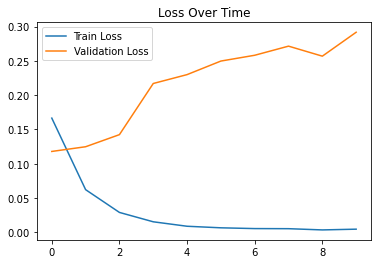

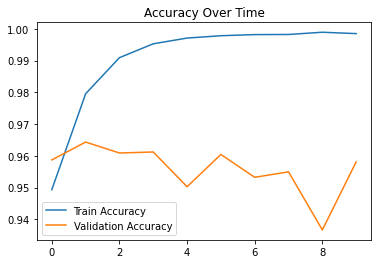

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.legend()
plt.show()

Observamos que en este caso, la red sufre sobreentrenamiento a pesar de haber implementado Dropout, un callback EarlyStopping y reducir el numero de celdas de memoria de las capas LSTM con respecto al anterior enfoque. Esto puede deberse a que para implementar este tipo de enfoque, precisariamos un dataset más amplio.

## Conclusiones

Para el proyecto, hemos utilizado 2 enfoques distintos para dar solución al problema, el primero es utilizar el modelo Word2Vec para crear embeddings y después entrenar una red LSTM para que clasifique los tweets en base a esos embeddings. El segundo es directamente utilizar una red LSTM, en la que las palabras se representan inicialmente como one-hot vectors y luego se utiliza una capa de embedding para aprender una representación vectorial más densa y significativa de las palabras durante el entrenamiento.

Cabe destacar las ventajas de cada uno de los enfoques.

· Usar Word2Vec y después LSTM:
    -La representación de palabras adquiere significado semántico y sintáctico, ya que Word2Vec es capaz de capturar la similitud entre palabras basada en su contexto en el corpus de entrenamiento.
    -Los embeddings previamente entrenados como Word2Vec pueden ahorrar tiempo de entrenamiento y requerir menos datos porque ya han aprendido a representar palabras de manera efectiva.
    
· Usar LSTM directamente:
    -Al entrenar la capa de embedding junto con el resto de la red LSTM, los embeddings pueden adaptarse específicamente a la tarea que se está resolviendo (en este caso, la clasificación de tweets).
    -No necesitas un paso adicional para generar los embeddings con un modelo como Word2Vec.
    
Por último, mencionar que se ha barajado y probado a implementar una solución con transformers utilizando modelos BERT, pero debido al gran coste computacional que conllevaban se ha descartado esa opción.